# CBIR WITH SIFT

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

We define the following functions to display the results:

In [2]:
def get_n_similar(n, counts, reverse):
    sorted_counts = sorted(counts.items(), key=lambda x:x[1], reverse=reverse)[:n] #Ordeno y me quedo con los 5 más parecidos
    sorted_indexes = [idx[0] for idx in sorted_counts]
    return sorted_indexes

def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("The value of n must be greater than 0")
        return

    if n > len(sorted_indexes):
        print(f"There are only {len(sorted_indexes)} images in the list. Showing all.


")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        

    plt.show()

In [4]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'./dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Returns a dictionary where the key is (folder, id), and the values are the paths.

# We store the paths of all images.

In [3]:
n_imgs = 100
folders = ["bus-n04487081", "nails-n03804744", "car-n02814533", "collar-n03814639", "plunger-n03970156",
           "cats-n02123394", "monkey-n02480495", "bridges-n04532670", "chair-n04099969", "dog-n02099601",
           "duck-n01855672", "pizza-n07873807", "sea-n09428293", "ipod-n03584254", "banana-n07753592", "gas_mask-n03424325",
           "bow_tie-n02883205", "fly-n02190166", "ice_cream-n07615774", "cannon-n02950826"]
len(folders)


20

In [5]:
images_path = get_images_path(folders, n_imgs)
len(images_path)

2000

## We see how SIFT works.


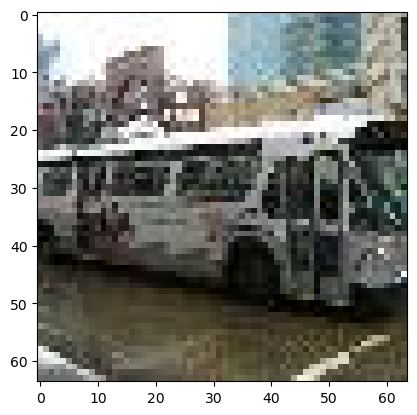

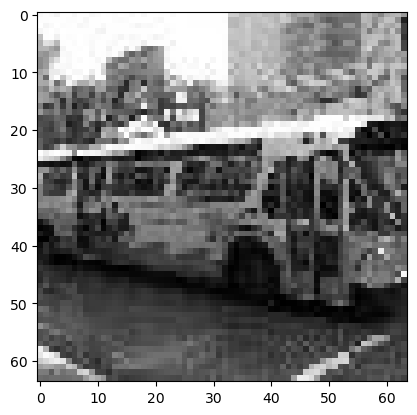

In [251]:
new_image_path = list(images_path.values())[random.randrange(0, len(folders)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
plt.imshow(new_img)
plt.show()
gray_im = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_im, cmap='gray')
plt.show()

We see that when applying SIFT to an image, an indefinite number of descriptors are generated, which depends on the image. Each descriptor is defined by a vector of 128 values.

# We apply SIFT to all our images.


We create a numpy array where we will store all the descriptors with the label of the image to which they belong.

In [8]:
if os.path.exists('./npy_mat/SIFT_descriptors.npy'):
    descriptors = np.load('./npy_mat/SIFT_descriptors.npy')
else:
    sift = cv2.SIFT_create()
    descriptors = np.empty((0,130))
    for idx in images_path:
        gray_im = cv2.cvtColor(cv2.imread(images_path[idx]), cv2.COLOR_BGR2GRAY)
        _, descriptor = sift.detectAndCompute(gray_im, mask=None)
        descriptors_arr = np.array(descriptor)
        if np.any(descriptors_arr):    
            descriptors_arr = np.insert(descriptors_arr, 0, idx[1], axis=1)
            descriptors_arr = np.insert(descriptors_arr, 0, idx[0], axis=1)
            descriptors =  np.vstack([descriptors, descriptors_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen
    np.save('SIFT_descriptors', descriptors)
descriptors.shape

(72594, 130)

# SIFT BASED ON COUNTS

In [350]:
n_neighbors = 50
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(descriptors_train)

NearestNeighbors(metric='euclidean', n_neighbors=50)

## We obtain the images most similar to a new image.

The strategy for determining the most similar images will be as follows:

We obtain for each descriptor of the new image its N closest descriptors.
We obtain the IDs of the images to which these descriptors belong.
We store in a dictionary the number of times a descriptor from each image appears.
We retrieve the n images with the highest number of descriptors matching those of the new image.

In [357]:
counts = {}
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)

_ , new_descriptors = sift.detectAndCompute(new_img, mask=None)
for descriptor in new_descriptors:
    descriptor = descriptor.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor, n_neighbors=n_neighbors)
    for idx in indice[0]:
        carpeta = str(int(descriptors[idx,0]))
        num_img = str(int(descriptors[idx,1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += 1
        else:
            counts[id] = 1

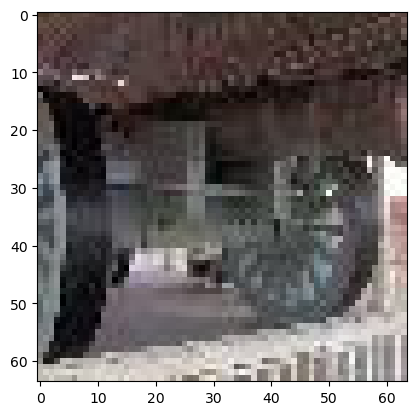

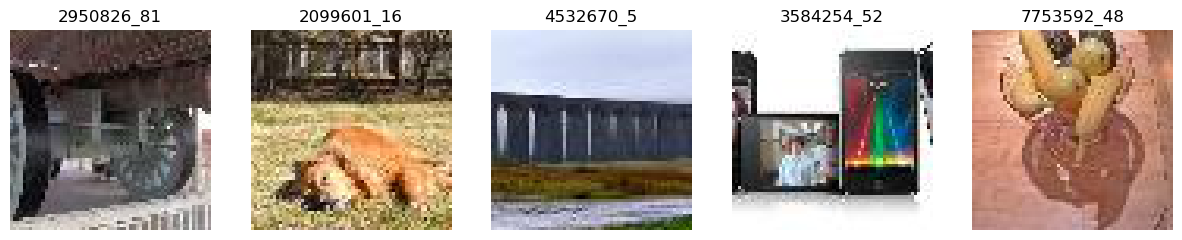

In [358]:
plt.imshow(new_img)
idx_similar = get_n_similar(5, counts, 1)
display_n_similar(idx_similar, 5)

## SIFT BASED ON DISTANCES

Ahora implementaremos otra forma de medir la similaridad entre 2 imagenes. Ahora, en vez de quedarnos con los n vecinos mas cercanos vamos a obtener todos, y de esta forma obtendremos todas las combinaciones posibles entre descriptores y obtendremos sus respectivas distancias.

Una vez tenemos las distancias de cada descriptor de cada imagen procedemos a calcular la media de las distancias, de forma que las imagenes se organizaran segun la media de distancias de sus descriptores.

In [294]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = len(descriptors)
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto', metric='euclidean')

descriptors_train = descriptors[:, 2:]
knn.fit(descriptors_train)

counts = {}

new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)]
new_img = cv2.cvtColor(cv2.imread(new_image_path), cv2.COLOR_BGR2RGB)
_ , descriptor = sift.detectAndCompute(new_img, mask=None)
descriptors_arr = np.array(descriptor)
for descriptor_i in descriptor:
    descriptor_i = descriptor_i.reshape(1, -1)
    distance, indice = knn.kneighbors(descriptor_i, n_neighbors=n_neighbors)
    idx_dist = list(zip(indice[0], distance[0]))
    for tupl in idx_dist:
        carpeta = str(int(descriptors[tupl[0],0]))
        num_img = str(int(descriptors[tupl[0],1]))
        id = (carpeta, num_img)
        if id in counts:
            counts[id] += [tupl[1]]
        else:
            counts[id] = [tupl[1]]

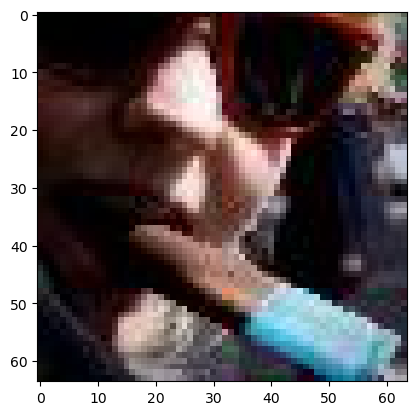

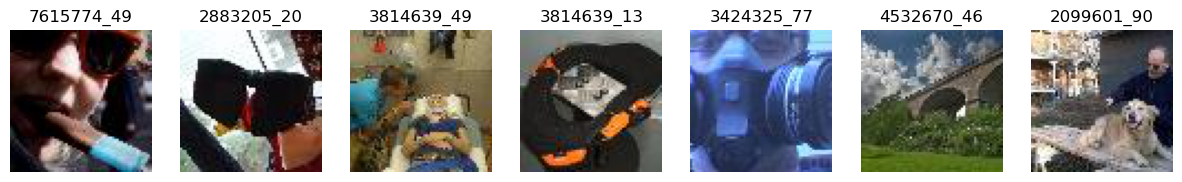

In [295]:
from statistics import mean
avg_distances = {clave: mean(valores) for clave, valores in counts.items()}
plt.imshow(new_img)
sorted_indexes = get_n_similar(7, avg_distances, 0)
display_n_similar(sorted_indexes, 7)

## SIFT BASED ON MATCHING

Solo hay 2 imágenes en la lista. Mostrando todas.


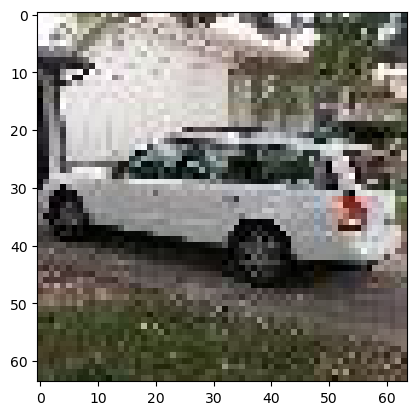

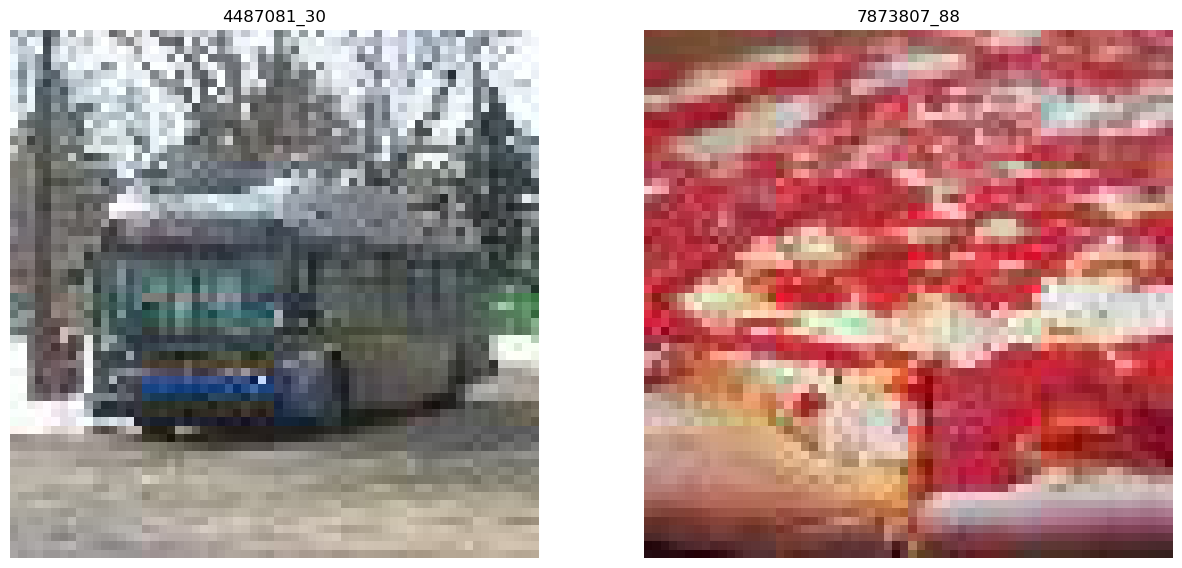

In [86]:
sift = cv2.SIFT_create()
descriptors_train = descriptors[:, 2:]

# Crear un objeto Brute-Force Matcher
bf = cv2.BFMatcher()

# Definir la imagen de consulta y extraer sus descriptores SIFT
new_img = cv2.cvtColor(cv2.imread('./dataset/test/coches-/n02814533_189.JPEG'), cv2.COLOR_BGR2RGB)
query_keypoints, query_descriptors = sift.detectAndCompute(new_img, mask=None)
descriptors_train = descriptors_train.astype(np.float32)


# Realizar la búsqueda de coincidencias entre la imagen de consulta y la base de datos
matches = bf.knnMatch(query_descriptors, descriptors_train, k=2)

# Filtrar las coincidencias con un umbral Lowe's ratio
good_matches = []
for m, n in matches:
    if m.distance < 0.85 * n.distance:
        good_matches.append(m)

pos = [m.trainIdx for m in good_matches]
ids = []
for idx in pos:
        carpeta = str(int(descriptors[idx,0]))
        num_img = str(int(descriptors[idx,1]))
        ids.append((carpeta, num_img))
plt.imshow(new_img)
display_n_similar(ids, 5)